In [132]:
import pandas as pd
from lenskit import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit import crossfold as xf
from lenskit import topn
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter



In [58]:
ratings = pd.read_csv("./dataset/XWines_Full_21M_ratings.csv")

C:\Users\nikch\AppData\Local\Temp\ipykernel_19372\2858274365.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv("./dataset/XWines_Full_21M_ratings.csv")


In [98]:
wines = pd.read_csv("./dataset/XWines_Full_100K_wines.csv")

# 1. Playing with the data

In [2]:
ratings.head(2)

,RatingID,UserID,WineID,Vintage,Rating,Date
0,1,1604441,136103,1950,4.0,2019-10-14 11:20:52
1,2,1291483,136103,1950,5.0,2019-11-28 03:36:33


In [99]:
display(wines.head(2))
print(wines.shape)

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200..."


(100646, 17)


### Preprocessing features - Grapes, Harmonize, Vintages

In [102]:
# Convert string to list
wines['Grapes'] = wines['Grapes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines['Harmonize'] = wines['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines['Vintages'] = wines['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [61]:
all_harmonize_items = [item for sublist in wines['Harmonize'].dropna() for item in sublist]

# Convert the list to a set to get unique items
unique_harmonize_items = set(all_harmonize_items)

# Count the number of unique items
num_unique_harmonize_items = len(unique_harmonize_items)

# Display the unique harmonize items and their count
print(f"Number of unique items in 'Harmonize': {num_unique_harmonize_items}")
print("Unique harmonize items:", unique_harmonize_items)


Number of unique items in 'Harmonize': 66
Unique harmonize items: {'Veal', 'Tagliatelle', 'Pizza', 'Yakissoba', 'Chocolate', 'Lasagna', 'Eggplant Parmigiana', 'Beef', 'Mushrooms', 'Grilled', 'Vegetarian', 'Cheese', 'Seafood', 'Dessert', 'Risotto', 'Soufflé', 'Rich Fish', 'Game Meat', 'Goat Cheese', 'Barbecue', 'Snack', 'Fish', 'Appetizer', 'Soft Cheese', 'Cookies', 'Shellfish', 'Baked Potato', 'Lean Fish', 'Dried Fruits', 'Fruit', 'Blue Cheese', 'Mild Cheese', 'Aperitif', 'Cake', 'Light Stews', 'Sashimi', 'Beans', 'Ham', 'Cured Meat', 'French Fries', 'Tomato Dishes', 'Cream', 'Medium-cured Cheese', 'Roast', 'Meat', 'Hard Cheese', 'Lamb', 'Chestnut', 'Curry Chicken', 'Maturated Cheese', 'Codfish', 'Spiced Fruit Cake', 'Citric Dessert', 'Pork', 'Asian Food', 'Spicy Food', 'Duck', 'Cold Cuts', 'Poultry', 'Chicken', 'Pasta', 'Sushi', 'Paella', 'Fruit Dessert', 'Sweet Dessert', 'Salad'}


In [62]:
all_grapes_items = [item for sublist in wines['Grapes'].dropna() for item in sublist]

# Convert the list to a set to get unique items
unique_grapes_items = set(all_grapes_items)

# Count the number of unique items
num_unique_grapes_items = len(unique_grapes_items)

# Display the unique grapes items and their count
print(f"Number of unique items in 'Grapes': {num_unique_grapes_items}")
print("Unique grapes items:", unique_grapes_items)


Number of unique items in 'Grapes': 777
Unique harmonize items: {"Roussette D'Ayze", 'Torrontés', 'Rieslaner', 'Negrara Trentino', 'Síria', 'Grechetto Rosso', 'Durif', 'Sciacarello', 'Manzoni Bianco', 'Muscat/Moscatel Roxo', 'Scheurebe', 'Arinarnoa', 'Verdejo', 'Caiño Tinto', 'Vidal Blanc', 'Nosiola', 'Ruländer', 'Sauvignon Gris', 'Bonamico', 'Muscat Black', 'Riesel', 'Tinta Carvalha', 'Roussanne', 'Sumoll', 'Cabernet Sauvignon', 'Garrido Fino', 'Lemberger', 'Swenson White', 'Gamba di Pernice', 'Prokupac', 'Vespolina', 'Chambourcin', 'Albillo de Albacete', 'Sercialinho', 'Côdega de Larinho', 'Ortega', 'Pinot Auxerrois', 'Muscardin', 'Incrocio Manzoni', 'Feteasca Alba', 'Airen', 'Cesanese', 'Muscat/Moscatel de Grano Menudo', 'Fonte Cal', 'Humagne Blanche', 'Piccola Nera', 'Gelber Muskateller', 'Nuragus', 'Folle Blanche', 'Hibernal', 'Trajadura', 'Tarrango', 'Piedirosso', 'Kydonitsa', 'Fer Servadou', "Nero d'Avola", 'Arnsburger', 'Romé', 'Saperavi', 'Nasco', 'Tsolikouri', 'Verdelho', 'Ve

In [63]:
all_vintages_items = [item for sublist in wines['Vintages'].dropna() for item in sublist]

# Convert the list to a set to get unique items
unique_vintages_items = set(all_vintages_items)

# Count the number of unique items
num_unique_vintages_items = len(unique_vintages_items)

# Display the unique harmonize items and their count
print(f"Number of unique items in 'Vintages': {num_unique_vintages_items}")
print("Unique vintages items:", unique_vintages_items)

Number of unique items in 'Vintages': 74
Unique vintages items: {1969, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 'N.V.', 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022}


#### Note: Lenskit expects the ratings frame to follow a naming convention:
User ID - user

Item ID - item

Rating - rating

Timestamp - timestamp

In [100]:
ratings = ratings.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})
wines = wines.rename(columns={'WineID': 'item'})

### Use one-hot encoding for "Harmonize"

In [103]:
#explode inti individual rows
wines_exploded = wines.explode('Harmonize')
print(wines_exploded.shape)
# one hot encode the harmonize column
harmonize_one_hot = pd.get_dummies(wines_exploded['Harmonize'], prefix='Harmonize')
# combine again into single row
harmonize_one_hot_grouped = harmonize_one_hot.groupby(wines_exploded['item']).sum()
# ensure we return to original shape
print(harmonize_one_hot_grouped.shape)

(423471, 17)
(100646, 66)


In [104]:
display(harmonize_one_hot_grouped.head(2))

,Harmonize_Aperitif,Harmonize_Appetizer,Harmonize_Asian Food,Harmonize_Baked Potato,Harmonize_Barbecue,Harmonize_Beans,Harmonize_Beef,Harmonize_Blue Cheese,Harmonize_Cake,Harmonize_Cheese,...,Harmonize_Soufflé,Harmonize_Spiced Fruit Cake,Harmonize_Spicy Food,Harmonize_Sushi,Harmonize_Sweet Dessert,Harmonize_Tagliatelle,Harmonize_Tomato Dishes,Harmonize_Veal,Harmonize_Vegetarian,Harmonize_Yakissoba
item,,,,,,,,,,,,,,,,,,,,,
100001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100002,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# Combine the one hot encoddings with the original df
wines = wines.merge(harmonize_one_hot_grouped, left_on='item', right_index=True, how='left')


In [106]:
# 66 harmonizers + 17 features = 83 columns expected
display(wines.head(2))

,item,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,...,Harmonize_Soufflé,Harmonize_Spiced Fruit Cake,Harmonize_Spicy Food,Harmonize_Sushi,Harmonize_Sweet Dessert,Harmonize_Tagliatelle,Harmonize_Tomato Dishes,Harmonize_Veal,Harmonize_Vegetarian,Harmonize_Yakissoba
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,[Muscat/Moscato],"[Pork, Rich Fish, Shellfish]",7.5,Medium-bodied,High,BR,...,0,0,0,0,0,0,0,0,0,0
1,100002,Ancellotta,Red,Varietal/100%,[Ancellotta],"[Beef, Barbecue, Codfish, Pasta, Pizza, Cheese]",12.0,Medium-bodied,Medium,BR,...,0,0,0,0,0,0,0,0,0,0


### Extract from vintages -> total number, oldest and most_recent vintage

In [110]:
wines['Vintages'] = wines['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)


In [120]:
# Count how many rows have 'N.V.' in the Vintages column
nv_count = wines['Vintages'].apply(lambda x: 'N.V.' in x and len(x) == 1).sum()
print(f"Number of 'N.V.' wines: {nv_count}")


Number of 'N.V.' wines: 97


In [121]:
def process_vintages(vintages):
    # Remove "N.V." from the list
    filtered_vintages = [vintage for vintage in vintages if vintage != "N.V."]

    # Calculate the number of vintages
    num_vintages = len(filtered_vintages)

    # Find the oldest and most recent vintages
    oldest_vintage = min(filtered_vintages) if filtered_vintages else 0
    most_recent_vintage = max(filtered_vintages) if filtered_vintages else 0

    return num_vintages, oldest_vintage, most_recent_vintage

# Apply the function to each row
wines[['num_vintages', 'oldest_vintage', 'most_recent_vintage']] = wines['Vintages'].apply(process_vintages).tolist()

In [123]:
display(wines.head(3))

,item,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,...,Harmonize_Sushi,Harmonize_Sweet Dessert,Harmonize_Tagliatelle,Harmonize_Tomato Dishes,Harmonize_Veal,Harmonize_Vegetarian,Harmonize_Yakissoba,num_vintages,oldest_vintage,most_recent_vintage
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,[Muscat/Moscato],"[Pork, Rich Fish, Shellfish]",7.5,Medium-bodied,High,BR,...,0,0,0,0,0,0,0,36,1966,2020
1,100002,Ancellotta,Red,Varietal/100%,[Ancellotta],"[Beef, Barbecue, Codfish, Pasta, Pizza, Cheese]",12.0,Medium-bodied,Medium,BR,...,0,0,0,0,0,0,0,13,2001,2016
2,100003,Cabernet Sauvignon,Red,Varietal/100%,[Cabernet Sauvignon],"[Beef, Lamb, Poultry]",12.0,Full-bodied,High,BR,...,0,0,0,0,0,0,0,23,1960,2021


### Use encodings for the grapes list

In [130]:
# Create a new column 'Grapes_Length' to store the length of each Grapes list
wines['Grapes_Length'] = wines['Grapes'].apply(len)
multiple_grape_wines  = wines[wines['Grapes_Length'] >= 2]

print("Number of wines with multiple grapes:", multiple_grape_wines.shape[0])
is_sorted = multiple_grape_wines['Grapes'].apply(lambda grapes: grapes == sorted(grapes))

# Count the number of wines with sorted grapes
count_sorted_wines = is_sorted.sum()

print("Number of wines with sorted grapes:", count_sorted_wines)

Number of wines with multiple grapes: 28150
Number of wines with sorted grapes: 9010


In [ ]:
# First, convert the list of grapes into a single string (e.g., 'Muscat/Moscato, Chardonnay')
wines['Grapes_str'] = wines['Grapes'].apply(lambda x: ','.join(x))

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply the TF-IDF transformation to the 'Grapes_str' column
tfidf_matrix = vectorizer.fit_transform(wines['Grapes_str'])

# Convert the TF-IDF matrix into a dataframe with the grape names as feature columns
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Merge the TF-IDF dataframe back into the original wines dataframe
wines = pd.concat([wines.reset_index(drop=True), tfidf_df], axis=1)

### Check if there are duplicate wines

In [5]:
params_to_check = ['WineName', 'Type', 'Elaborate', 'Grapes', 'ABV', 'Body', 'Acidity', 'RegionID', 'WineryID']
# Check for duplicate wines based on specific columns
duplicate_wines_count = wines[params_to_check].duplicated().sum()
print(f"Number of duplicate wines: {duplicate_wines_count}")

# Find and print the duplicate rows
duplicate_wines = wines[wines[params_to_check].duplicated(keep=False)]
#duplicate_wines.to_csv('duplicate_wines.csv', index=False)

print("Duplicate wines have been exported to 'duplicate_wines.csv'.")


Number of duplicate wines: 22
Duplicate wines have been exported to 'duplicate_wines.csv'.


In [3]:
ratings_data = ratings[['user', 'item', 'rating', 'timestamp']]
ratings_data.head()

,user,item,rating,timestamp
0,1604441,136103,4.0,2019-10-14 11:20:52
1,1291483,136103,5.0,2019-11-28 03:36:33
2,1070605,104036,5.0,2017-12-28 10:15:55
3,1080181,144864,5.0,2016-06-23 02:16:22
4,1834379,111430,5.0,2021-05-16 17:58:14


### Checking distributions 

,user
item,
155289,27415
179010,23626
179011,21216
111391,20913
167418,20817
...,...
191683,5
191682,5
191681,5


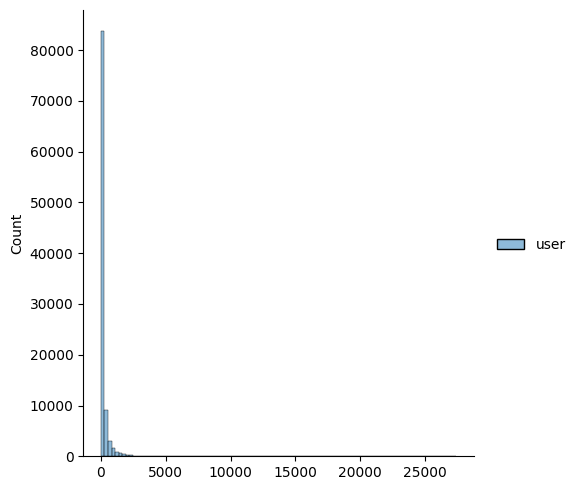

In [7]:
count_rating_df = ratings_data[['user', 'item']].groupby('item').count()
display(count_rating_df.sort_values('user', ascending=False))
# distribution of user ratings across items
sns.displot(data=count_rating_df, bins=100)

In [8]:
x = 1000
wines_with_more_than_x_ratings = count_rating_df[count_rating_df['user'] >= x]
cnt = len(wines_with_more_than_x_ratings)
print(cnt)
print(cnt / len(count_rating_df) * 100) 



3758
3.73387914075075


In [9]:
print(wines_with_more_than_x_ratings['user'].sum())

8630733


In [10]:
total_users = ratings_data['user'].nunique()
print(total_users)


1056079


,item
user,
1084433,2986
1034989,2979
1070878,2613
1048267,2597
1160536,2392
...,...
1979157,5
1096801,5
1537952,5


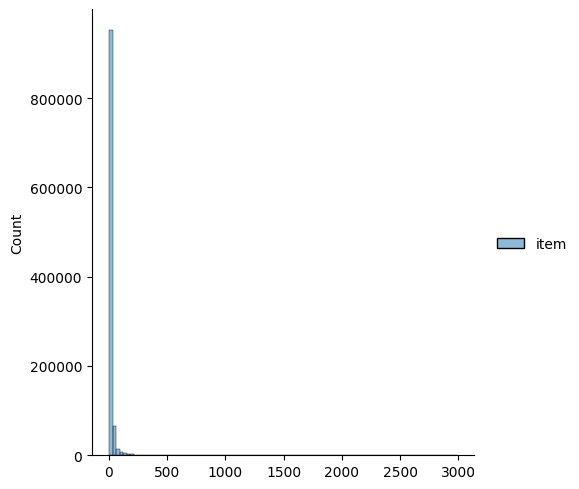

In [11]:
user_count_rating_df = ratings_data[['user', 'item']].groupby('user').count()
display(user_count_rating_df.sort_values('item', ascending=False))
# distribution of user ratings across items, we see that 
sns.displot(data=user_count_rating_df, bins=100)

In [12]:
x = 100
users_with_more_than_x_ratings = user_count_rating_df[user_count_rating_df['item'] >= x]
cnt = len(users_with_more_than_x_ratings)
print(cnt)
print(cnt / len(user_count_rating_df) * 100) 



21877
2.0715306335984334


In [13]:
print(users_with_more_than_x_ratings['item'].sum())

4763006


### Explore how frequent reviewers evaluate the same wine

In [57]:
duplicate_user_item_pairs = ratings_data[['user', 'item']].duplicated().sum()
print(f"Number of duplicate user-item pairs: {duplicate_user_item_pairs}")


Number of duplicate user-item pairs: 422736


In [26]:
# Group by user and item, then count how many times each pair appears
duplicate_user_item_counts = ratings_data.groupby(['user', 'item']).size().reset_index(name='count')


### The X most active users were selected from those who have rated the same wine at least Y times

In [128]:
# Filter out pairs where the user has rated the same wine more than once
multiple_ratings = duplicate_user_item_counts[duplicate_user_item_counts['count'] >= 5]

# Display the users who have rated the same wine multiple times
multiple_ratings = multiple_ratings.sort_values('count', ascending=False)


top_user_count = 1000
top_users = multiple_ratings.head(top_user_count)

multiple_ratings_details = pd.merge(ratings_data, top_users[['user', 'item']], on=['user', 'item'], how='inner')
user_stats = multiple_ratings_details.groupby(['user', 'item']).agg(
    rating_mean=('rating', 'mean'),
    rating_median=('rating', 'median'),
    rating_std=('rating', 'std'),
    rating_variance=('rating', 'var'),
    rating_min=('rating', 'min'),
    rating_max=('rating', 'max'),
    rating_count=('rating', 'count')
).reset_index()

# Display the stats for each user-item pair
print(user_stats)


        user    item  rating_mean  rating_median  rating_std  rating_variance  \
0    1000096  111520     5.000000            5.0    0.000000         0.000000   
1    1000141  138328     5.000000            5.0    0.000000         0.000000   
2    1000495  136229     5.000000            5.0    0.000000         0.000000   
3    1000858  111391     5.000000            5.0    0.000000         0.000000   
4    1001293  111435     5.000000            5.0    0.000000         0.000000   
..       ...     ...          ...            ...         ...              ...   
995  2052434  102130     4.111111            4.0    0.333333         0.111111   
996  2053489  155381     4.000000            4.0    0.000000         0.000000   
997  2056705  111395     4.714286            5.0    0.487950         0.238095   
998  2059912  162541     4.000000            4.0    0.000000         0.000000   
999  2061195  111391     4.500000            4.5    0.408248         0.166667   

     rating_min  rating_max

In [125]:
avg_std = user_stats['rating_std'].mean()
avg_variance = user_stats['rating_variance'].mean()

# Print the results
print(f"Average Standard Deviation: {avg_std}")
print(f"Average Variance: {avg_variance}")

Average Standard Deviation: 0.1263528763896445
Average Variance: 0.047212818894426876


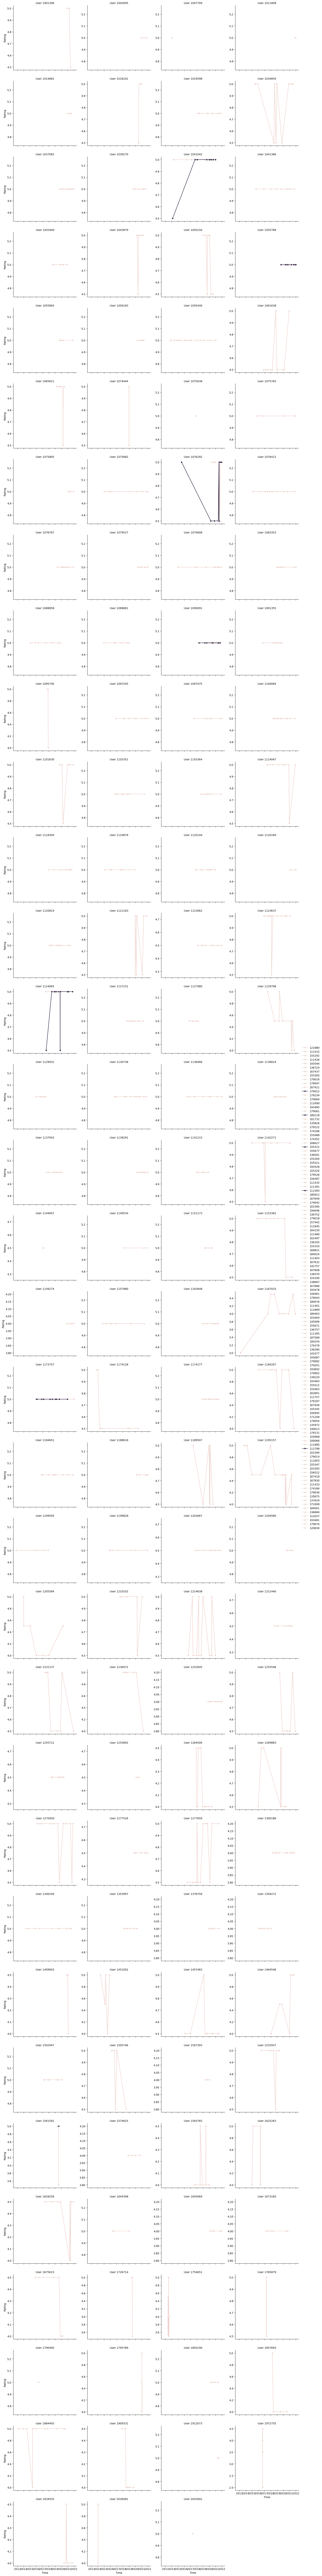

In [101]:
# Ensure 'timestamp' is in datetime format
multiple_ratings_details['timestamp'] = pd.to_datetime(multiple_ratings_details['timestamp'])

# Create a FacetGrid for individual user plots
g = sns.FacetGrid(multiple_ratings_details, col='user', col_wrap=4, height=4, sharex=True, sharey=False)

# Plot each user's ratings over time
g.map_dataframe(sns.lineplot, x='timestamp', y='rating', hue='item', marker='o')

# Add titles and labels
g.set_titles(col_template='User {col_name}')
g.set_axis_labels("Time", "Rating")
g.add_legend()

plt.show()

interesting users: 1754651, 1129796, 1167033, 1195157, 1205584, 1214638, 1754651


### check if a good item stays good - plot ratings of good and bad wines over time

In [40]:
wine_stats = ratings_data.groupby('item').agg(
    review_count=('rating', 'count'), 
    avg_rating=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_variance=('rating', 'var')
).reset_index()
num_reviews = 100
wine_count = 100
# Filter wines with at least 100 reviews
top_wines = wine_stats[wine_stats['review_count'] >= num_reviews]


best_wines = top_wines.nlargest(wine_count, 'avg_rating')

worst_wines = top_wines.nsmallest(wine_count, 'avg_rating')

random_wines = top_wines.sample(wine_count, random_state=55)

# Calculate average standard deviation and variance for the best wines
avg_std_best = best_wines['rating_std'].mean()
avg_variance_best = best_wines['rating_variance'].mean()

# Calculate average standard deviation and variance for the worst wines
avg_std_worst = worst_wines['rating_std'].mean()
avg_variance_worst = worst_wines['rating_variance'].mean()

# Calculate average standard deviation and variance for the random wines
avg_std_random = random_wines['rating_std'].mean()
avg_variance_random = random_wines['rating_variance'].mean()

# Print the results
print(f"Best Wines - Average Standard Deviation: {avg_std_best}, Average Variance: {avg_variance_best}")
print(f"Worst Wines - Average Standard Deviation: {avg_std_worst}, Average Variance: {avg_variance_worst}")
print(f"Random Wines - Average Standard Deviation: {avg_std_random}, Average Variance: {avg_variance_random}")

Best Wines - Average Standard Deviation: 0.4173558631959894, Average Variance: 0.1796649132581469
Worst Wines - Average Standard Deviation: 0.9223121132375411, Average Variance: 0.8691044650980169
Random Wines - Average Standard Deviation: 0.6453994614217448, Average Variance: 0.42606305113603327


In [39]:
wine_stats.head()

,item,review_count,avg_rating,rating_std,rating_variance
0,100001,2625,4.134476,0.735254,0.540598
1,100002,10,3.500000,1.000000,1.000000
2,100003,62,3.379032,0.705282,0.497422
3,100004,110,3.172727,0.813973,0.662552
4,100005,72,2.965278,0.968978,0.938918


In [36]:
best_wines.head()

,item,review_count,avg_rating
17324,117346,157,4.942675
82145,182257,155,4.922581
17638,117660,146,4.900685
75217,175325,121,4.888430
82421,182533,135,4.874074


In [21]:
display(best_wines)

,item,review_count,avg_rating
17324,117346,157,4.942675
82145,182257,155,4.922581
17638,117660,146,4.900685


In [23]:
wine_ids = [117346, 182257, 117660]
top_wine_ratings = ratings_data[ratings_data['item'].isin(wine_ids)]


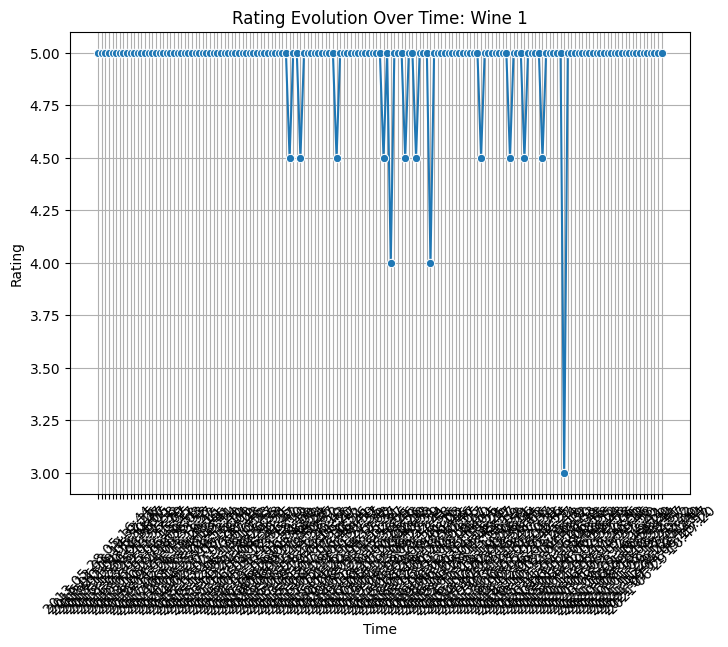

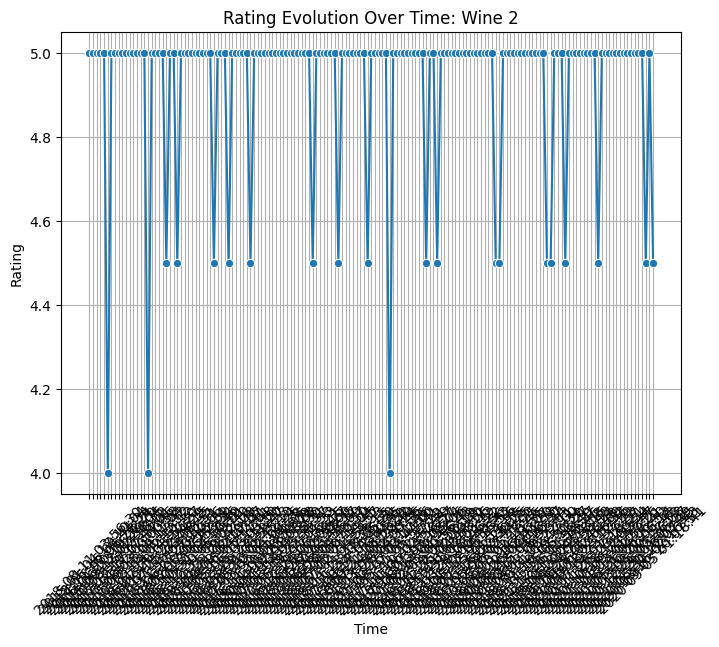

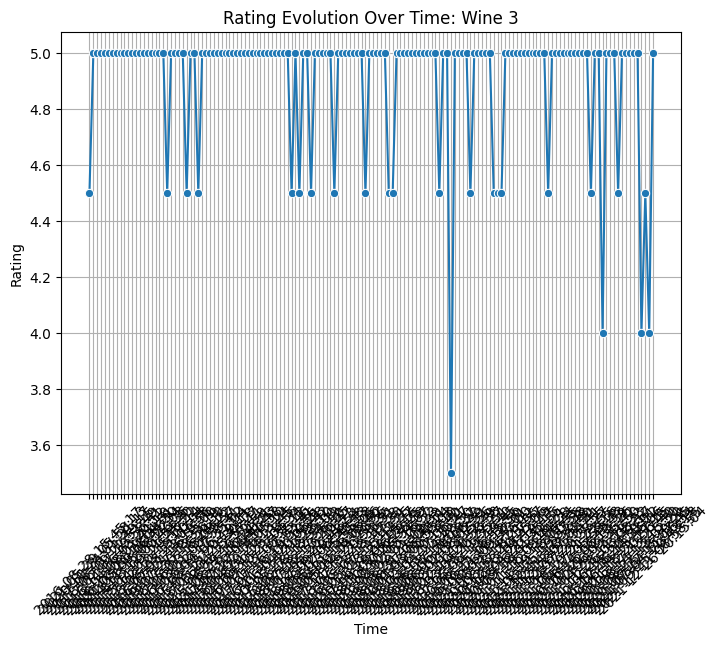

In [24]:
wines_dict = {117346: 'Wine 1', 182257: 'Wine 2', 117660: 'Wine 3'}

# Iterate through each wine and plot
for wine_id, wine_name in wines_dict.items():
    # Filter data for the specific wine
    wine_data = top_wine_ratings[top_wine_ratings['item'] == wine_id]
    
    # Create a smooth line plot for ratings over time
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=wine_data, x='timestamp', y='rating', errorbar=None, marker='o')
    plt.title(f"Rating Evolution Over Time: {wine_name}")
    plt.xlabel("Time")
    plt.ylabel("Rating")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

check distribution of ratings

# 2. Algorithms

### user-user functionalities

In [45]:
# TO DO: optimize the number of neighbors
uu_model = UserUser(10)
recs = Recommender.adapt(uu_model)
recs.fit(ratings_data)

In [42]:
# try a recommendation
predicted_rating = uu_model.predict_for_user(1604441, [100001])
print(predicted_rating)

item
100001    4.242063
Name: prediction, dtype: float64


In [46]:
user_recs = recs.recommend(1604441, 10)
print(user_recs)

     item     score
0  124687  5.911667
1  124285  5.899944
2  130872  5.870000
3  129481  5.508889
4  139559  5.478732
5  172661  5.463750
6  140459  5.453333
7  117153  5.432500
8  182897  5.420000
9  146747  5.409063


### Non-personalized algos - useful as naive baselines. Check popular, bias, random